# Spectral extraction code for MIRI and NIRSpec

## Preparing the dataset

The packages used are simple. I recommend to use Astroconda package 

In [12]:
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
import glob, os
import pandas as pd
import time
from matplotlib.pyplot import figure
import math as mt

time0 = time.perf_counter()

We define the directory where our cube is, called spec_dir. We must specify if we are extracting a uber cube (channels 1,2,3 and 4) or a subband cube (1-2-3-4 s-m-l). We specify this with the variables channel and band. In filesave is where our results will be stored. 

Low and up idebtify the limits of your spectral range. These must be inside the manifold of the spectral range of your cube. Finally scale is only used to change the units to the ones I want to use. If you want to use the standard JWST units, scale must be 1. According to the documentation, the PSF of MIRIsim is ovsersized, so we must multiply the intensity 1.1 times. If with the real data this is dixed, remove the line of 'scale=scale*1.1'.
molec stores the information of the molecules to invert. If molec is 0 in every position, it only creates a spectra. If molec[0]=1, it inverts the temperature. The rest correspond to a certain molecule. If you want to invert one, put a 2 in that position.

In [13]:
spec_dir = '/home/povalle/notebook/data_products/'
channel = '2'  # 1 // 2 // 3 // 4 // all
band = 'short' # shor // medi // long // all
filesave = '/home/povalle/notebook/extraction/data/'
low = 1250
up= 1325
scale = 1e6*1e-26/((3.335641e-11)*1e4) # Changing to W/cm2 sr cm-1
scale = scale*1.1 # because of the oversized PSF of MIRIsim (REMOVE WITH REAL DATA)
molec = [1,0,2,0,0,0] # molecules to invert (in this case tempreature and nh3)

#We write the filename for a specific subband

if channel=='all':
    filename = spec_dir + 'allcube_ch1-2-3-4-mediumshortlong-_s3d.fits'
else:
    filename = spec_dir + 'Level3_ch' + str(channel) + '-' + str(band) + '_s3d.fits'

We open the fits cube, and plot it only to check everything is ok. We save some parameters such as the reference pixel and the RA and DEC of that reference pixel.

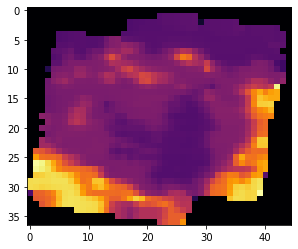

In [14]:
hdu = fits.open(filename)
hdr = hdu['SCI'].header
data = hdu['SCI'].data
plt.imshow(data[100,:,:], cmap='inferno')
RA = hdu['SCI'].header['RA_V1']
DEC = hdu['SCI'].header['DEC_V1']
CRPIX1 = hdu['SCI'].header['CRPIX1']
CRPIX2 = hdu['SCI'].header['CRPIX2']

The simlatuion has been done by using MIRIsim. If you want to create one, check the directory where it is stored.

The specification of the wavenumber varies depending on the data structure. Also there can be a shift in the final data. If in your dataset you don't have shifts (congrats!) remove the line.

In [15]:
ny = data.shape[1]
nx = data.shape[2]

if channel=='all':
    wave = hdu['WCS-TABLE'].data['wavelength'][0] #IF WORKING WITH 4 CHANNEL CUBE
else:    
    wave = np.arange(hdr['NAXIS3'])*hdr['CDELT3']+hdr['CRVAL3'] #IF WORKING WITH 1 CHANNEL or SUBBAND CUBE
    
wave = wave + 0.0033 # Shift, probably only in MIRIsim
wave = np.array(wave)
print(nx, ny, wave.shape)

45 37 (631,)


We are doing serious business here. Hence, we use wavenumbers. Forget about that childish wavelength and transform your dataset in wavenumber. We take the exact limits in our wavenumber array.

In [16]:
# Define the limits low and up for the range of wavenumbers

wavenumber = 10**4/wave
for ix in range(len(wavenumber)):
            if wavenumber[ix] < low:
                lower = ix
                break
for iix in range(len(wavenumber)):
            if wavenumber[iix] < up:
                upper = iix
                break

## Starting the extraction

We sweep across our 2D image, and will extract the spectra for every one of these spaxels. We need to save for every spaxel the spectra with the number of points, and the .fuel file (explained in inversion repository). 
1. We check if there is info in this spaxel. If there is no info, we move to the next one.
2. If there is info, we create the good format for .spe, with wavenumber, intensity and the error. 
3. We save this file and counth the number of points. After that we write it in the header of the file.
4. We must also develop a way to know the latitude and longitude of the spaxel. Here I show you a super naive way that cannot be used normally.  A next data structure in the fits file itslef will contain data about the lat and lon in every spaxel.
5. We create the .fuel, with data about the latitude, the emission angle, and the molecules we want to invert.
6. We check how much time takes to the inversion (around 10 sec.).

In [17]:
time0 = time.perf_counter()

for i in range(ny):
    for ii in range(nx):       

# 1
        if int(sum(data[10:260,i,ii])) == 0:  # IT IS NOT TAKING INTO ACCOUNT CHANNEL 4 (Change if needed)
            pass

        else:  
# 2            
            spe = data[:,i,ii]
            spe = spe*scale
            error = hdu['ERR'].data[:,i,ii]
            error = error*scale
            d = {'wavel': wave, 'spe': spe, 'error':error}
            df = pd.DataFrame(data=d)
            df['wavel']=10**4/df['wavel']
            df=df.iloc[::-1]          
            df = df.loc[lower:upper]
        
            df['wavel'] = df['wavel'].map('{:.2f}'.format)
            df['spe'] = df['spe'].map('{:.5e}'.format)
            df['error'] = df['error'].map('{:.5e}'.format)  
# 3
            newfilesave = filesave + str("{:02}".format(i)) + '-' + str("{:02}".format(ii)) + '-jupiter_ch4.spe'        
            df.to_csv(newfilesave  , header=None, 
                  index=None, sep=' ')
            size=len(df)
            filename1=newfilesave
            line='0'
            def line_prepender(filename1, line):
                with open(filename1, 'r+') as f:
                    content = f.read()
                    f.seek(0, 0)
                    f.write(str(size) + '\n' + content)

            line_prepender(filename1,line)
            file1=newfilesave
            with open(file1, 'r') as file :
              filedata = file.read()
            filedata = filedata.replace(' ','  ')
            filedata = filedata.replace('\n','\n      ')
            with open(file1, 'w') as file:
              file.write(filedata)
# 4            
###############################################################################################
            
            latmid = -22 # Lat in the middle of the image
            lonmid = 10 # Lon in the middle of the image
            pixlat = 0.71 # lat degrees per pixel
            pixlon = 0.53 # lon degrees per pixel
    
            theta1 = 0 
            phi1 = 0
            #theta2 = latmid - (18-i)*pixlat  #empirical way
            theta2 = -12.758
            phi2 = lonmid + (22-ii)*pixlon    #empirical way
            theta1r = mt.radians(theta1)
            phi1r = mt.radians(phi1) 
            theta2r = mt.radians(theta2) 
            phi2r= mt.radians(phi2) 
            #costheta = np.sin(theta1r)*np.sin(theta2r)+np.cos(theta1r)*np.cos(theta2r)*np.cos(phi1r-phi2r)
            costheta = 1

###############################################################################################            
# 5            
            theta2 = '{0:.3f}'.format(theta2)
            costheta = '{0:.3f}'.format(costheta)
            fuelname = filesave + str("{:02}".format(i)) + '-' + str("{:02}".format(ii)) + '-jupiter_ch4.fuel'
            
            f  = open(fuelname, "w+")
            f.write(str(theta2) + ' ! latitude (degree)\n')
            f.write('  1.000 ! cos(incidence angle)\n')
            f.write('  ' + str(costheta) + ' ! cos(incidence angle)\n')
            f.write('  \n')
            f.write('  0.500 ! fwhm (cm-1)\n')
            f.write('  \n')
            f.write('    ch5 1.000E+00 ' + str(molec[0]) + '\n')
            f.write('   ch3e 1.624E+03 ' + str(molec[1]) + '\n')
            f.write('    nh3 1.000E+00 ' + str(molec[2]) + '\n')
            f.write('    ph3 1.000E+00 ' + str(molec[3]) + '\n')
            f.write('   c2h3 1.000E+00 ' + str(molec[4]) + '\n')
            f.write('   c2h6 1.000E+00 ' + str(molec[5]) + '\n')
            f.close()        
# 6
time1 = time.perf_counter()
print(f"Runtime of the extraction: {time1 - time0:0.1f} seconds")
time2=(time1 - time0)/60
print(f"Runtime of the extraction: {time2:0.1f} minutes")
print(' ')
print('Saved in ' + filesave)

Runtime of the extraction: 6.0 seconds
Runtime of the extraction: 0.1 minutes
 
Saved in /home/povalle/notebook/extraction/data/
